In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import urllib

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [5]:
def temp_pred():
    data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
    urllib.request.urlretrieve(data_url, 'daily-min-temperatures.csv')

    time_step = []
    temps = []

    with open('daily-min-temperatures.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        step = 0
        for row in reader:
            temps.append(float(row[1]))
            time_step.append(step)
            step += 1

    series = np.array(temps)

    # Normalization
    min_val = np.min(series)
    max_val = np.max(series)
    series = (series - min_val) / (max_val - min_val)
    time = np.array(time_step)

    split_time = 2500

    time_train = time[:split_time]
    x_train = series[:split_time]
    time_valid = time[split_time:]
    x_valid = series[split_time:]

    window_size = 64
    batch_size = 256
    shuffle_buffer_size = 1000


    train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                  metrics=['mae']
                  )

    history = model.fit(train_set,
                        epochs=100,
                        verbose=0)  # Set verbose to 0 to suppress training output

    plt.plot(history.history['mae'], label='MAE (training data)')
    plt.title('MAE for Daily Min Temperature Prediction')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    return model

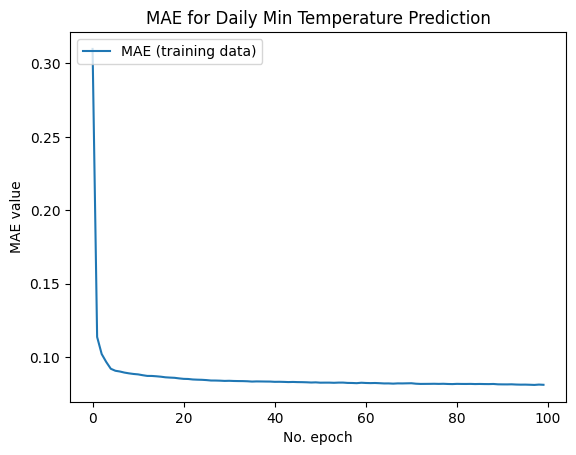

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# Save model as a .h5 file.
if __name__ == '__main__':
    model = temp_pred()
    model.save("model_C5.h5")